In [1]:
# !mkdir -p ~/.kaggle

# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
# !kaggle datasets download -d jangedoo/utkface-new

# 降级TensorFlow版本为2.15

In [3]:


!pip install tensorflow==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully unin

In [1]:
import tensorflow as tf
print(tf.__version__)

# 验证GPU是否可用
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2.15.0
GPU Available:  []


# 数据导入

In [2]:
# https://drive.google.com/file/d/1-0QiyFCLXQIcVFUtNT1dZr3ygmHbxRJE/view?usp=sharing

file_id = '1-0QiyFCLXQIcVFUtNT1dZr3ygmHbxRJE'
import gdown

# 下载文件
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-0QiyFCLXQIcVFUtNT1dZr3ygmHbxRJE
From (redirected): https://drive.google.com/uc?id=1-0QiyFCLXQIcVFUtNT1dZr3ygmHbxRJE&confirm=t&uuid=74960731-93ab-4c77-9859-031ac0bf269a
To: /content/dataset.zip
100%|██████████| 347M/347M [00:02<00:00, 150MB/s]


'dataset.zip'

In [3]:
# !cp /content/utkface-new.zip /content/drive/My\ Drive/AI_notebooks/dataset/face_dataset/

In [4]:
# !cp  /content/drive/MyDrive/dataset/dataset/face_dataset/utkface-new.zip /content/utkface-new.zip

In [5]:
!unzip -q /content/dataset.zip

# 导入Python包

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from PIL import Image, ImageFilter

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing import image

tf.__version__

'2.15.0'

In [7]:
# !unzip /content/utkface-new.zip

# 数据预处理

## 初始化变量

In [8]:
# configs
DATA_DIR = '/content/UTKFace'
# ! ls /home/jackon/datasets/UTKFace/UTKFace | wc -l

TRAIN_TEST_SPLIT = 0.7
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
IMAGE_CHANNELS = 3
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = {g: i for i, g in ID_GENDER_MAP.items()}
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = {r: i for i, r in ID_RACE_MAP.items()}

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

## 生成dataframe数据

In [9]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None, None

In [10]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

df_origin = pd.DataFrame(attributes)
df_origin['file'] = files
df_origin.columns = ['age', 'gender', 'race', 'file']
df_origin = df_origin.dropna()
df_origin.head()

error to parse /content/UTKFace/61_1_20170109150557335.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)
error to parse /content/UTKFace/61_1_20170109142408075.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)
error to parse /content/UTKFace/39_1_20170116174525125.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)


,age,gender,race,file
0,82.0,female,white,/content/UTKFace/82_1_0_20170110184132973.jpg....
1,33.0,female,black,/content/UTKFace/33_1_1_20170114030609784.jpg....
2,40.0,female,asian,/content/UTKFace/40_1_2_20170116222648635.jpg....
3,31.0,female,black,/content/UTKFace/31_1_1_20170116231912509.jpg....
4,2.0,female,others,/content/UTKFace/2_1_4_20161221192715844.jpg.c...


In [11]:
attributes[:5]

[(82, 'female', 'white'),
 (33, 'female', 'black'),
 (40, 'female', 'asian'),
 (31, 'female', 'black'),
 (2, 'female', 'others')]

## 分析数据

In [12]:

df_origin.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


<Axes: xlabel='race', ylabel='age'>

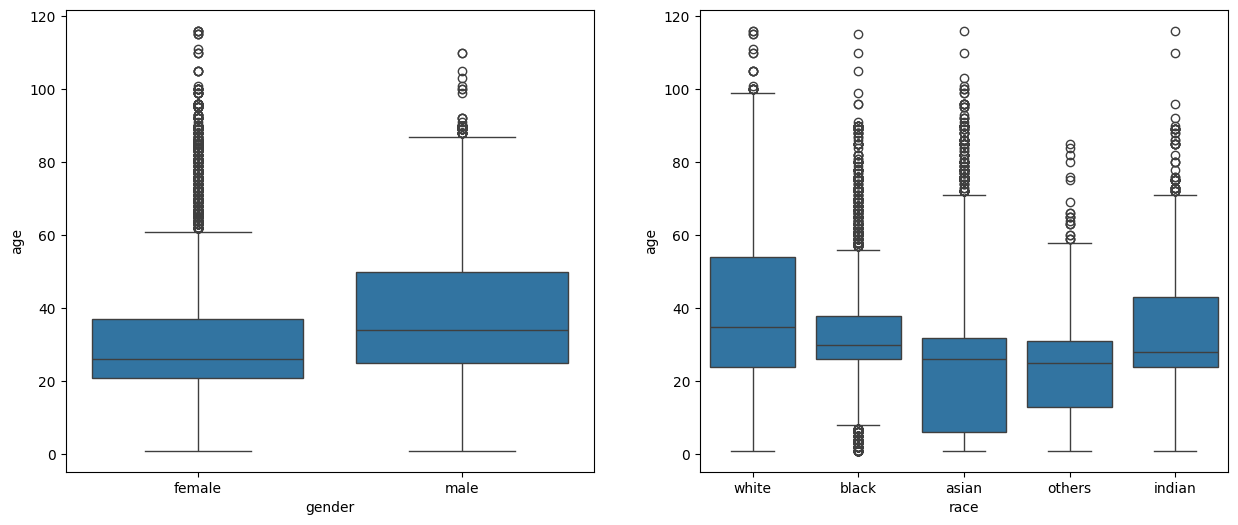

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=df_origin, x='gender', y='age', ax=ax1)
sns.boxplot(data=df_origin, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

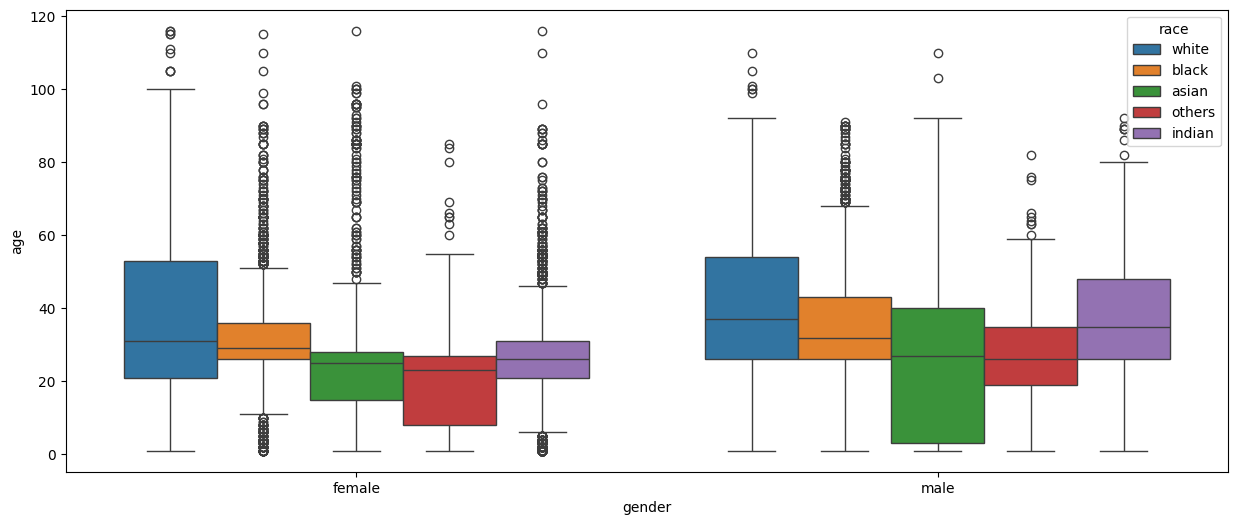

In [14]:

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_origin, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

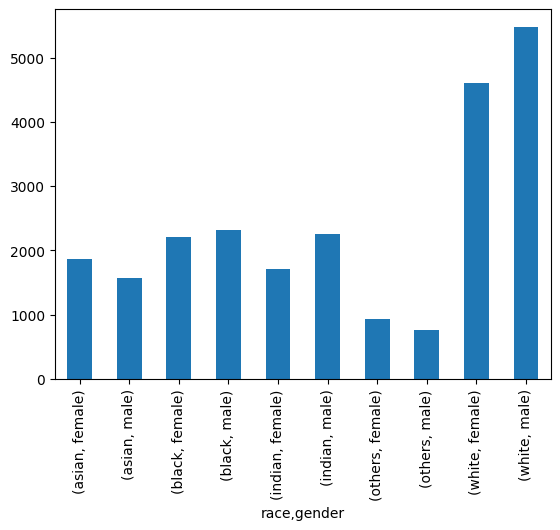

In [15]:
df_origin.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

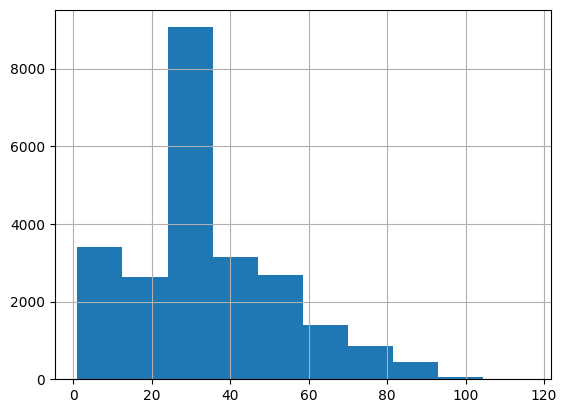

In [16]:
df_origin['age'].hist()

In [17]:
df_origin['age'].describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [18]:
# df = df_origin.copy()
# 选择200条数据快速跑通代码，跑全部数据选择上面那段代码
df = df_origin[:300].copy()
df = df[(df['age'] > 10) & (df['age'] < 65)]
df.describe()

,age
count,229.000000
mean,34.043668
std,11.778952
min,12.000000
25%,26.000000
50%,31.000000
75%,42.000000
max,62.000000


In [19]:
df.head()

,age,gender,race,file
1,33.0,female,black,/content/UTKFace/33_1_1_20170114030609784.jpg....
2,40.0,female,asian,/content/UTKFace/40_1_2_20170116222648635.jpg....
3,31.0,female,black,/content/UTKFace/31_1_1_20170116231912509.jpg....
5,57.0,male,white,/content/UTKFace/57_0_0_20170105173211517.jpg....
6,28.0,male,white,/content/UTKFace/28_0_0_20170119194800515.jpg....


## 数据预处理和生成器

In [20]:
import tensorflow as tf

In [21]:

p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
print('train count: %s, valid count: %s, test count: %s, max age: %s' % (
    len(train_idx), len(valid_idx), len(test_idx), max_age))

train count: 112, valid count: 48, test count: 69, max age: 62.0


In [22]:


def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

# 数据增强模块添加

In [23]:
img_path = '/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x_one = image.img_to_array(img)
x_one = np.expand_dims(x_one, axis=0)
x_one.shape

(1, 224, 224, 3)

In [24]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,3)),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.03),
    # layers.RandomBrightness(0.05)
    layers.GaussianNoise(0.8)
  ]
)

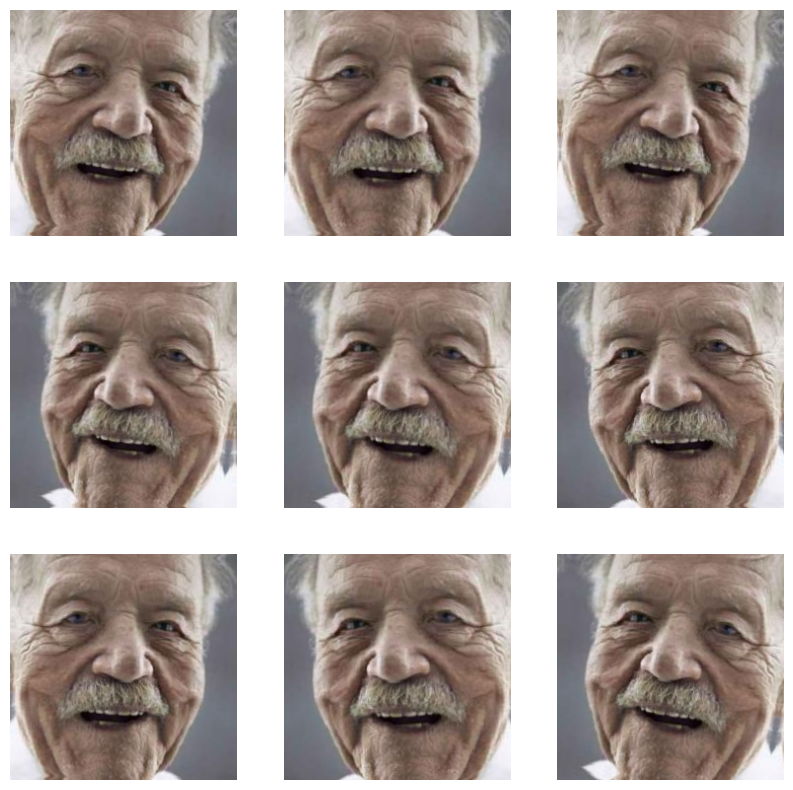

In [25]:
plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
for i in range(9):
  augmented_images = data_augmentation(x_one)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

# 超参数定义

In [26]:
batch_size = 32
valid_batch_size = 32

# 普通模型

## 模型构建

In [27]:


def conv_block(input_data, filters=32, bn=True, pool=True, kernel_size=3, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation)(input_data)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
input_layer = data_augmentation(input_layer)
x = conv_block(input_layer, filters=32, bn=False, pool=False)
x = conv_block(x, filters=32*2)
x = conv_block(x, filters=32*3)
x = conv_block(x, filters=32*4)
x = conv_block(x, filters=32*5)
x = conv_block(x, filters=32*6)
bottleneck = GlobalMaxPool2D()(x)

# for age calculation
age_x = Dense(128, activation='relu')(bottleneck)
age_output = Dense(1, activation='sigmoid', name='age_output')(age_x)

# for race prediction
race_x = Dense(128, activation='relu')(bottleneck)
race_output = Dense(len(RACE_ID_MAP), activation='softmax', name='race_output')(race_x)

# for gender prediction
gender_x = Dense(128, activation='relu')(bottleneck)
gender_output = Dense(len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender_x)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop',
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'categorical_crossentropy'},
              loss_weights={
                  'age_output': 2.,
                  'race_output': 1.5,
                  'gender_output': 1.},
              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 220, 220, 64)         18496     ['conv2d[1][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 220, 220, 64)         256       ['conv2d_1[1][0]']            
 Normalization)                                                                               

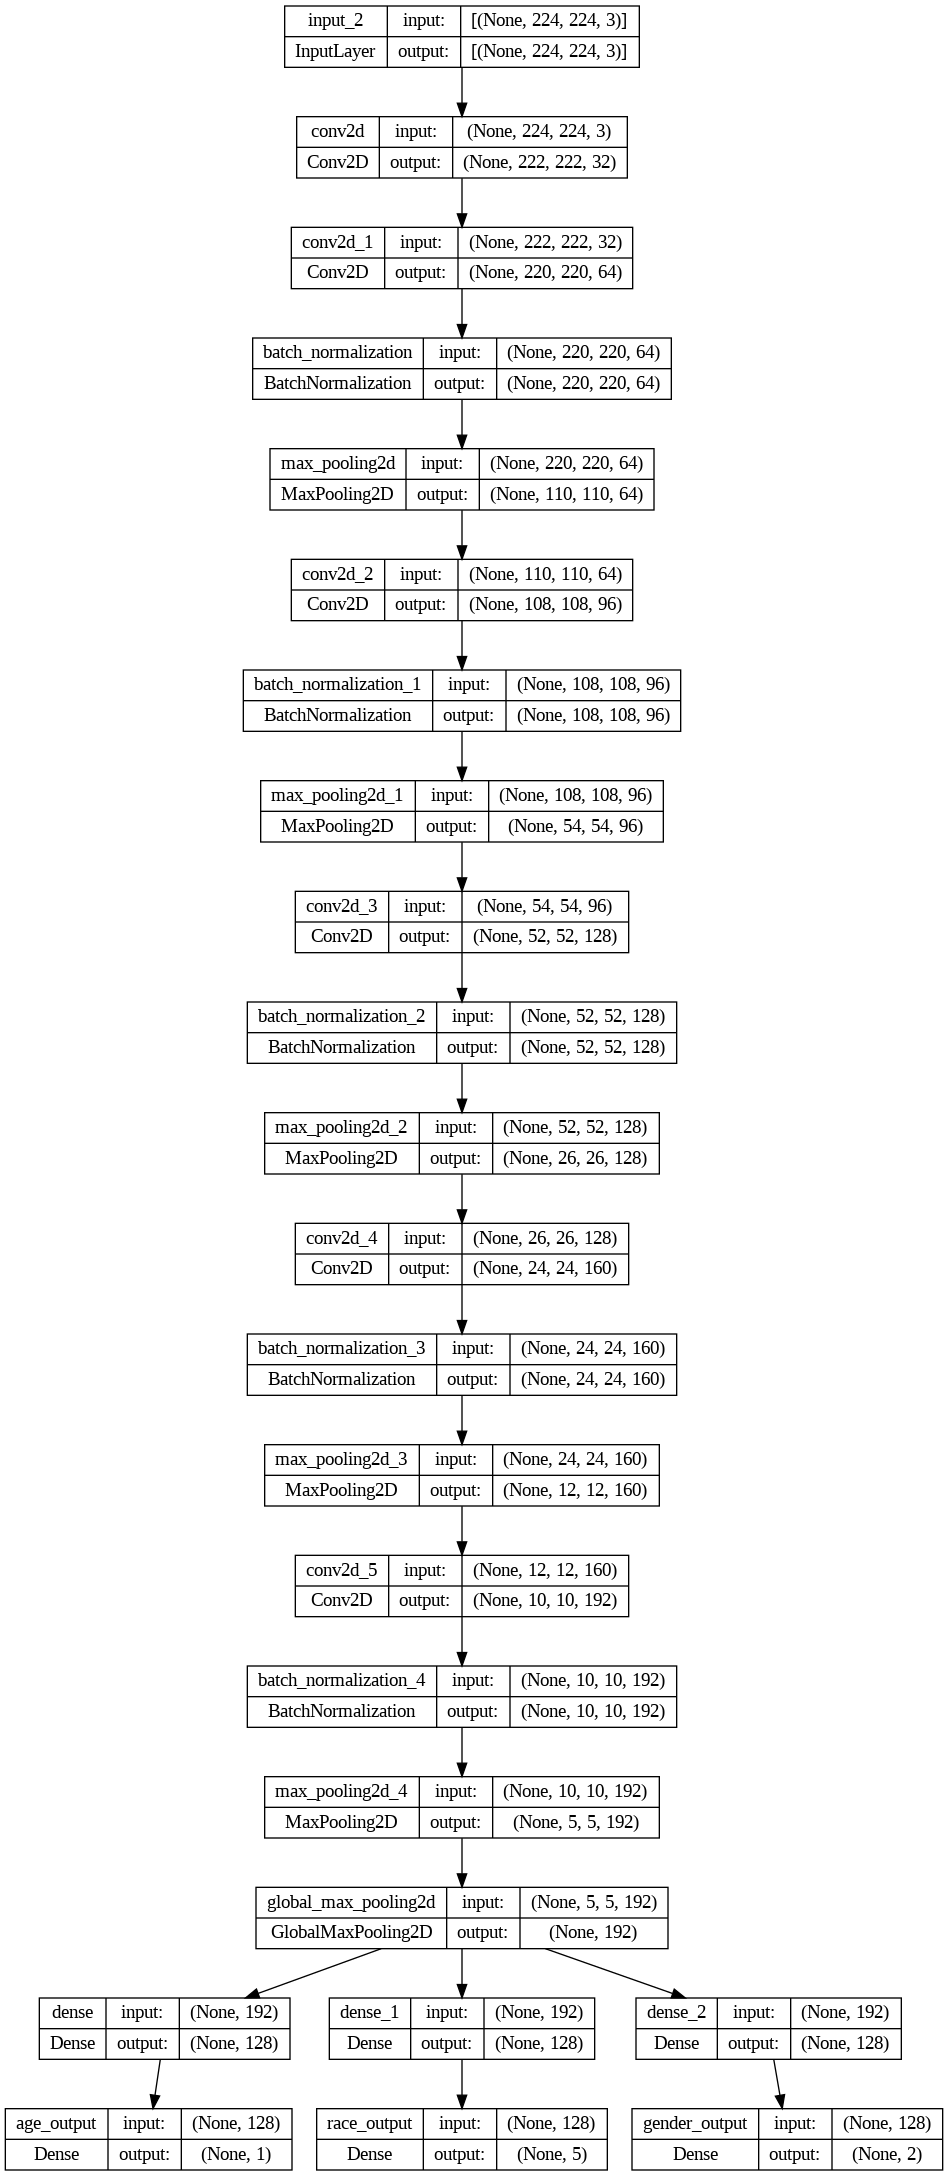

In [28]:
import tensorflow as tf
tf.keras.utils.plot_model(model,show_shapes=True)

## 模型训练

In [29]:



train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

# callbacks = [
#     ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]
save_model_path = '/content/save/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=save_model_path,
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=2,
                    # callbacks=model_checkpoint_callback,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
3/3 [==============================] - 36s 12s/step - loss: 9.9589 - age_output_loss: 0.2518 - race_output_loss: 4.0471 - gender_output_loss: 3.3846 - age_output_mae: 0.4635 - race_output_accuracy: 0.4062 - gender_output_accuracy: 0.4479 - val_loss: 3.2202 - val_age_output_loss: 0.0332 - val_race_output_loss: 1.6443 - val_gender_output_loss: 0.6874 - val_age_output_mae: 0.1514 - val_race_output_accuracy: 0.1250 - val_gender_output_accuracy: 0.5312
Epoch 2/2
3/3 [==============================] - 35s 12s/step - loss: 4.5202 - age_output_loss: 0.1690 - race_output_loss: 2.0867 - gender_output_loss: 1.0521 - age_output_mae: 0.3672 - race_output_accuracy: 0.3646 - gender_output_accuracy: 0.6354 - val_loss: 3.1439 - val_age_output_loss: 0.0411 - val_race_output_loss: 1.5820 - val_gender_output_loss: 0.6886 - val_age_output_mae: 0.1579 - val_race_output_accuracy: 0.4375 - val_gender_output_accuracy: 0.5938


In [30]:

print('\n'.join(history.history.keys()))

loss
age_output_loss
race_output_loss
gender_output_loss
age_output_mae
race_output_accuracy
gender_output_accuracy
val_loss
val_age_output_loss
val_race_output_loss
val_gender_output_loss
val_age_output_mae
val_race_output_accuracy
val_gender_output_accuracy


In [31]:
history.history

{'loss': [9.958946228027344, 4.520234107971191],
 'age_output_loss': [0.25184252858161926, 0.1690233200788498],
 'race_output_loss': [4.0471367835998535, 2.08674693107605],
 'gender_output_loss': [3.3845560550689697, 1.0520673990249634],
 'age_output_mae': [0.46352052688598633, 0.367239385843277],
 'race_output_accuracy': [0.40625, 0.3645833432674408],
 'gender_output_accuracy': [0.4479166567325592, 0.6354166865348816],
 'val_loss': [3.220211982727051, 3.143862009048462],
 'val_age_output_loss': [0.03318547457456589, 0.0411374494433403],
 'val_race_output_loss': [1.6442673206329346, 1.5819599628448486],
 'val_gender_output_loss': [0.687440037727356, 0.6886469721794128],
 'val_age_output_mae': [0.1513548195362091, 0.15790431201457977],
 'val_race_output_accuracy': [0.125, 0.4375],
 'val_gender_output_accuracy': [0.53125, 0.59375]}

### 训练过程可视化

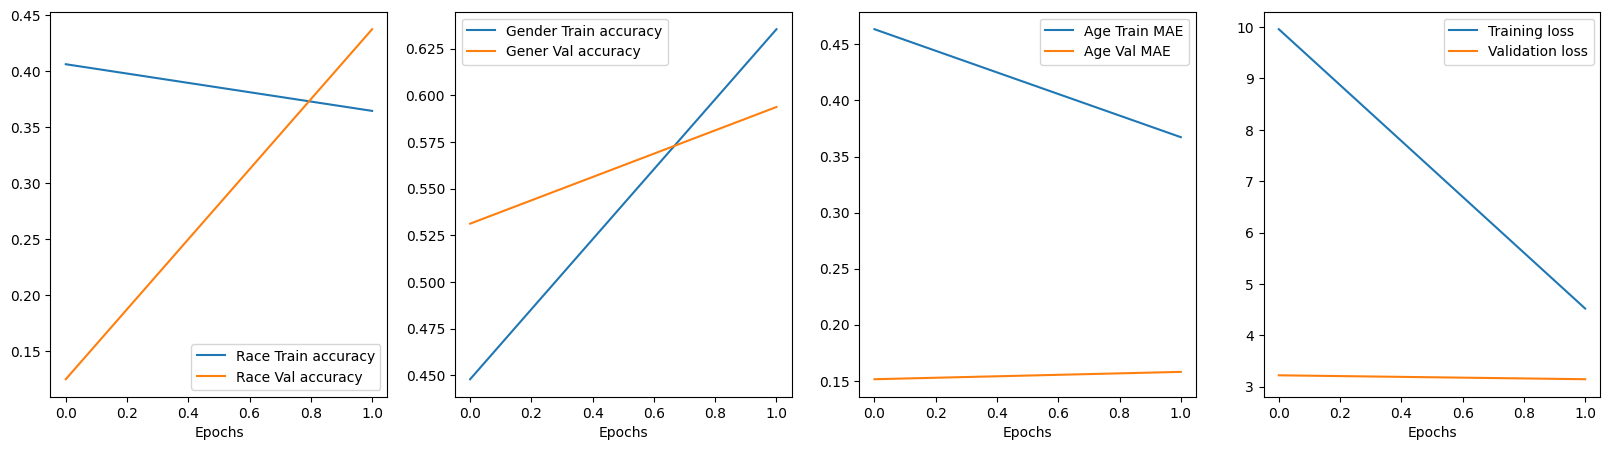

In [32]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

## 预测单张图片

In [33]:
# valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)
model.evaluate(valid_gen, steps=len(test_idx)//valid_batch_size)

2/2 [==============================] - 5s 3s/step - loss: 3.1535 - age_output_loss: 0.0400 - race_output_loss: 1.5896 - gender_output_loss: 0.6890 - age_output_mae: 0.1544 - race_output_accuracy: 0.4062 - gender_output_accuracy: 0.5781


[3.153484344482422,
 0.040020499378442764,
 1.589624047279358,
 0.689007043838501,
 0.15436172485351562,
 0.40625,
 0.578125]

## 模型预测

In [34]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=valid_batch_size)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//64)))

1/1 [==============================] - 3s 3s/step - loss: 3.1211 - age_output_loss: 0.0294 - race_output_loss: 1.5819 - gender_output_loss: 0.6893 - age_output_mae: 0.1423 - race_output_accuracy: 0.4062 - gender_output_accuracy: 0.5625


{'loss': 3.1210575103759766,
 'age_output_loss': 0.029445776715874672,
 'race_output_loss': 1.581899881362915,
 'gender_output_loss': 0.6893161535263062,
 'age_output_mae': 0.14229851961135864,
 'race_output_accuracy': 0.40625,
 'gender_output_accuracy': 0.5625}

In [35]:

test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=valid_batch_size)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

race_pred, gender_pred = tf.math.argmax(race_pred, axis=1), tf.math.argmax(gender_pred, axis=1)
race_true, gender_true = tf.math.argmax(race_true, axis=1), tf.math.argmax(gender_true, axis=1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [36]:
age_pred

array([[30.42592 ],
       [29.956728],
       [30.845762],
       [30.733955],
       [30.676157],
       [30.645552],
       [31.593071],
       [30.490637],
       [30.309523],
       [31.4311  ],
       [30.194937],
       [31.851704],
       [30.514961],
       [30.320498],
       [31.11915 ],
       [30.746351],
       [30.135027],
       [29.912565],
       [30.253448],
       [29.57647 ],
       [30.426975],
       [31.542542],
       [30.4866  ],
       [30.669508],
       [30.603666],
       [29.964989],
       [30.28959 ],
       [30.472645],
       [30.404858],
       [30.33699 ],
       [30.956898],
       [31.175377]], dtype=float32)

## 结果显示

/tmp/ipython-input-37-3643678822.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(age_pred[img_idx]),


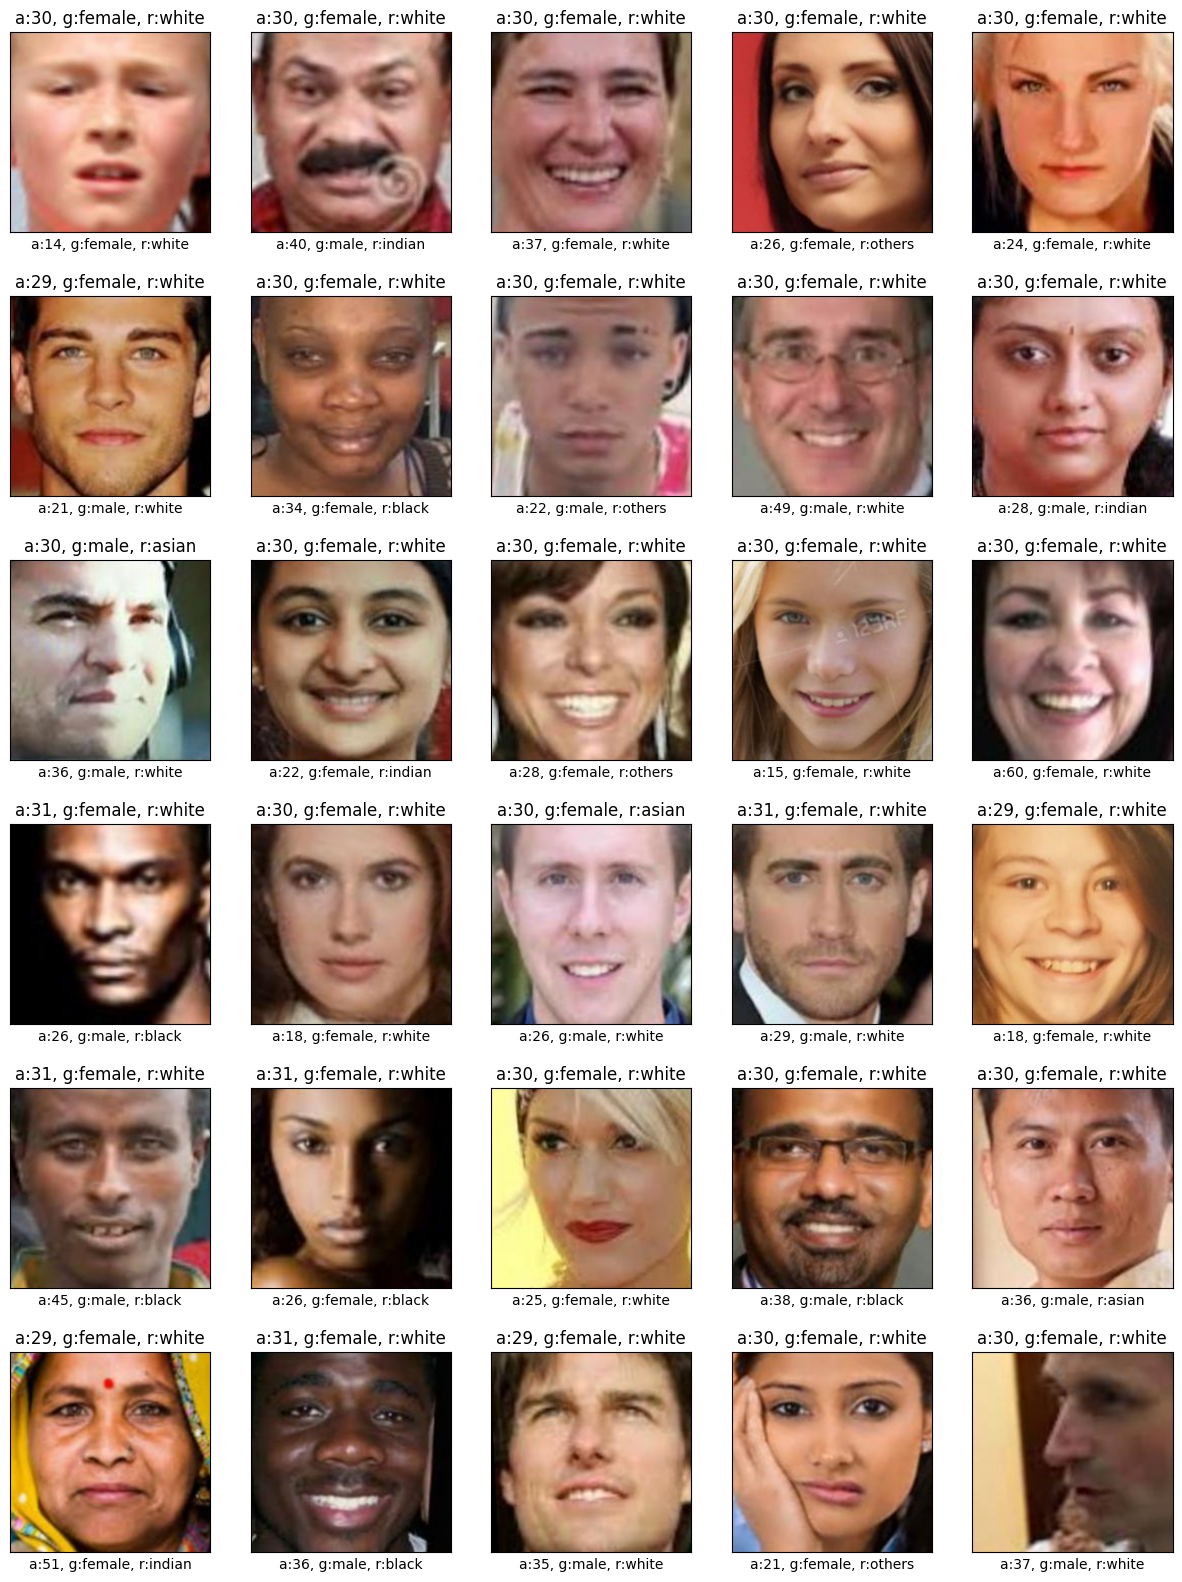

In [37]:

import math
import numpy
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(
        int(age_pred[img_idx]),
        ID_GENDER_MAP[gender_pred[img_idx].numpy()],
        ID_RACE_MAP[race_pred[img_idx].numpy()]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(
        int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx].numpy()], ID_RACE_MAP[race_true[img_idx].numpy()]))
    ax.set_xticks([])
    ax.set_yticks([])

## 使用classification_report 显示分类指标

In [38]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred, labels=list(ID_RACE_MAP.keys())))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred, labels=list(ID_GENDER_MAP.keys())))

Classification report for race
              precision    recall  f1-score   support

           0       0.43      0.87      0.58        15
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.41        32
   macro avg       0.09      0.17      0.12        32
weighted avg       0.20      0.41      0.27        32


Classification report for gender
              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.55      1.00      0.71        17

    accuracy                           0.56        32
   macro avg       0.77      0.53      0.42        32
weighted avg       0.76      0.56      0.43        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
